<a href="https://colab.research.google.com/github/phuonggtrann/DS-Unit-1-Build/blob/master/BuildWeek1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Blog post at https://phuonggtrann.github.io/2020-05-28-universe-age/

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [0]:
# https://en.wikipedia.org/wiki/Age_of_the_universe
predicted_age = 13.9

In [4]:
url = "https://raw.githubusercontent.com/zonination/galaxies/master/galaxies.csv"
# The last line contains ',' in the end therefore pandas has been throwing error
# Set error_bad_lines to False to eliminate "error" lines
df = pd.read_csv(url, error_bad_lines=False)
df

b'Skipping line 4241: expected 3 fields, saw 4\n'


,objname,mod0,vgsr
0,UGC12914,33.49,4522.0
1,PGC000143,24.94,-54.0
2,NGC7814,30.80,1204.0
3,UGC00014,35.03,7428.0
4,UGC00017,31.34,1024.0
...,...,...,...
4234,UGC06940,31.98,1184.0
4235,UGC06862,34.13,2658.0
4236,PGC083734,35.23,6268.0
4237,PGC090806,35.15,6031.0


In [5]:
# Checking type
df.dtypes

objname     object
mod0       float64
vgsr       float64
dtype: object

In [6]:
# Data cleaning, dropping NaNs
df = df.dropna()
df.isnull().sum()

objname    0
mod0       0
vgsr       0
dtype: int64

In [7]:
# Renaming column so it's easier to read
df = df.rename(columns={'objname': 'name', 'mod0' : 'distance-modulus', 'vgsr' : 'recorded-velocity'})
df.head()

,name,distance-modulus,recorded-velocity
0,UGC12914,33.49,4522.0
1,PGC000143,24.94,-54.0
2,NGC7814,30.80,1204.0
3,UGC00014,35.03,7428.0
4,UGC00017,31.34,1024.0


In [8]:
# Processing data: Calculate actual distance derive from distance modulus
# Using formula from https://en.wikipedia.org/wiki/Distance_modulus
# d = 10^(1+(dl/5))

## in mpc
df['derived-distance'] = (10**(1+(df['distance-modulus']/5)))/(1e6)

df.head()

,name,distance-modulus,recorded-velocity,derived-distance
0,UGC12914,33.49,4522.0,49.888449
1,PGC000143,24.94,-54.0,0.972747
2,NGC7814,30.80,1204.0,14.454398
3,UGC00014,35.03,7428.0,101.391139
4,UGC00017,31.34,1024.0,18.535316


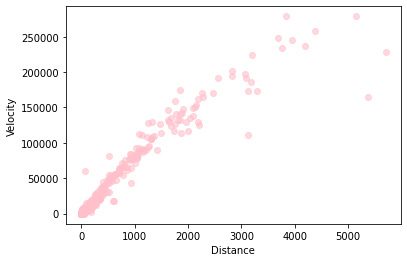

In [9]:
plt.scatter(df['derived-distance'],df['recorded-velocity'], c='pink', alpha = 0.6)
# Majority is close to origin
plt.xlabel("Distance")
plt.ylabel("Velocity")
plt.show()

In [10]:
# Using polynomial regression, deg=1 indicate linear
model = np.polyfit(df['derived-distance'],df['recorded-velocity'], deg=1) 
model # index 0 = slope and index 1 = y-intercept
predict = np.poly1d(model)
r2 = r2_score(df['recorded-velocity'], predict(df['derived-distance']))
print(r2) # r2 nearly 1 indicate a strong linear relationship

0.9342905641797816


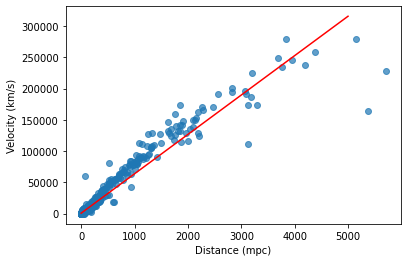

In [11]:
# Calcualting best fit line
lin_dist = range(0, 5000)
lin_vel = predict(lin_dist)

# Graphing
plt.scatter(df['derived-distance'],df['recorded-velocity'], alpha=0.7)
plt.plot(lin_dist, lin_vel, c='red') ## Best fit line 
plt.xlabel("Distance (mpc)")
plt.ylabel("Velocity (km/s)")
plt.show()

In [12]:
# model2[0] will be our "slope", in this case, will be our Hubble constant
# https://www.sciencepagenews.com/2019/08/27/hubble-constant-shows-something-is-fundamentally-wrong-with-our-conception-of-the-universe/
hubble_const = model[0]/(3.08*(1e19)) # Convert to km
print("Hubble constant is:", hubble_const)
age = 1/(hubble_const) # in seconds
# 1 year = 31556952 seconds
age = (age/31556952)/(1e9)
print("Age of the universe:", age) # Way off
# Need more data cleaning, wipe all outliers away

Hubble constant is: 2.044729159746761e-18
Age of the universe: 15.49776817910499


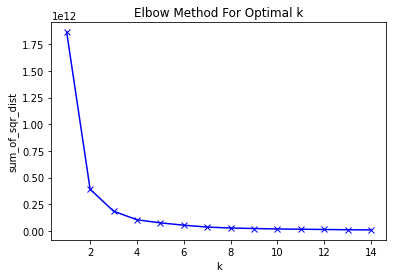

In [13]:
cluster_df = df.copy()
cluster_df = cluster_df[['derived-distance', 'recorded-velocity']]

sum_of_sqr_dist = []
for k in range(1, 15):
  km = KMeans(n_clusters=k)
  km = km.fit(cluster_df)
  sum_of_sqr_dist.append(km.inertia_)
plt.plot(range(1,15), sum_of_sqr_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_sqr_dist')
plt.title('Elbow Method For Optimal k')
plt.show()

# Choosing k = 4, that's when it shops decreasing between point of k

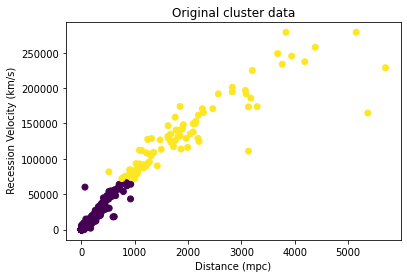

In [14]:
## Doing kmean, labels is for generating color
kmeans = KMeans(n_clusters=2)
kmeans.fit(cluster_df)
cluster_df['labels'] = kmeans.labels_
plt.scatter(cluster_df['derived-distance'], cluster_df['recorded-velocity'], c=cluster_df['labels'])
plt.title("Original cluster data")
plt.xlabel("Distance (mpc)")
plt.ylabel(" Recession Velocity (km/s)")
plt.show()

## Since purple one has the most crowded, we work with that cluster and treats others as outlier

In [0]:
# Recleaning data to see if we get a better shot at this
final_df = cluster_df[(cluster_df['labels']==0)] #| (cluster_df['labels']==3) ]
final_df = final_df[final_df['recorded-velocity']<50000]

In [20]:
# First find the age of the universe base on its
final_df['hubble-const-in-km'] =  (final_df['recorded-velocity'] / final_df['derived-distance'] ) /(3.08*(1e19))
final_df['uni-age'] = ((1/final_df['hubble-const-in-km'])/31556952)/(1e9) 
final_df = final_df.replace(np.inf, np.NaN)
final_df = final_df.dropna()
final_df['uni-age'] = final_df['uni-age'].apply(round)
final_df.head()

,derived-distance,recorded-velocity,labels,hubble-const-in-km,uni-age
0,49.888449,4522.0,0,2.942929e-18,11
1,0.972747,-54.0,0,-1.802366e-18,-18
2,14.454398,1204.0,0,2.704430e-18,12
3,101.391139,7428.0,0,2.378599e-18,13
4,18.535316,1024.0,0,1.793698e-18,18


In [21]:
age_dict = dict(final_df['uni-age'].value_counts())
age_dict

{-1796: 1,
 -476: 1,
 -197: 1,
 -173: 1,
 -165: 1,
 -152: 1,
 -123: 1,
 -116: 1,
 -112: 1,
 -108: 1,
 -98: 1,
 -97: 1,
 -73: 1,
 -72: 1,
 -64: 1,
 -63: 1,
 -55: 1,
 -52: 2,
 -50: 2,
 -46: 1,
 -45: 1,
 -43: 1,
 -38: 1,
 -37: 1,
 -35: 1,
 -34: 1,
 -32: 1,
 -26: 1,
 -23: 1,
 -18: 2,
 -14: 2,
 -13: 1,
 -11: 1,
 -9: 2,
 -8: 2,
 -7: 1,
 -6: 1,
 -5: 7,
 -4: 4,
 -3: 6,
 -2: 7,
 -1: 4,
 0: 11,
 1: 11,
 2: 5,
 3: 11,
 4: 15,
 5: 20,
 6: 35,
 7: 60,
 8: 97,
 9: 156,
 10: 230,
 11: 301,
 12: 363,
 13: 425,
 14: 426,
 15: 382,
 16: 293,
 17: 211,
 18: 180,
 19: 135,
 20: 90,
 21: 77,
 22: 71,
 23: 31,
 24: 33,
 25: 31,
 26: 25,
 27: 20,
 28: 16,
 29: 16,
 30: 11,
 31: 10,
 32: 7,
 33: 6,
 34: 7,
 35: 6,
 36: 10,
 37: 5,
 38: 2,
 39: 5,
 40: 5,
 41: 5,
 42: 2,
 43: 2,
 44: 2,
 45: 1,
 46: 1,
 47: 2,
 48: 2,
 49: 3,
 50: 1,
 51: 2,
 54: 1,
 56: 1,
 58: 2,
 59: 1,
 62: 2,
 63: 1,
 65: 3,
 67: 1,
 69: 1,
 70: 1,
 79: 2,
 85: 4,
 87: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 99: 1,
 107: 1,
 112: 1,
 115: 2,


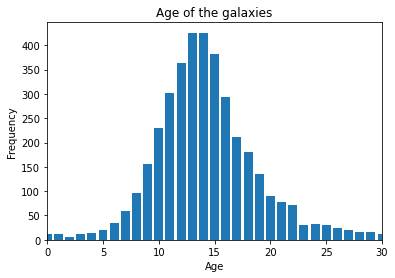

In [26]:
plt.bar(age_dict.keys(), age_dict.values())
plt.xlim(0, 30)
plt.title("Age of the galaxies")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#### Galaxies with 13-14 billions year has the most frequency -> conclude that uni age is around 13-14 bil year

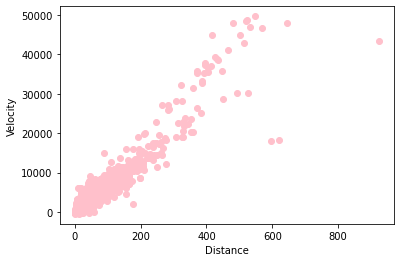

In [16]:
## Redo all the step above
plt.scatter(final_df['derived-distance'], final_df['recorded-velocity'], c='pink')
plt.xlabel("Distance")
plt.ylabel("Velocity")
plt.show()

In [17]:
# Using polynomial regression, deg=1 indicate linear
model2 = np.polyfit(final_df['derived-distance'], final_df['recorded-velocity'], deg=1) 
model2 # index 0 = slope and index 1 = y-intercept
predict2 = np.poly1d(model2)
new_r2 = r2_score(final_df['recorded-velocity'], predict(final_df['derived-distance']))
print(new_r2) # r2 nearly 1 indicate a strong linear relationship

0.8792176872062871


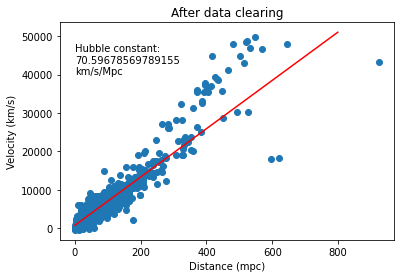

In [18]:
# Calcualting best fit line
lin_dist = range(0, 800)
lin_vel = predict(lin_dist)

# Graphing
plt.scatter(final_df['derived-distance'],final_df['recorded-velocity'])
plt.plot(lin_dist, lin_vel, c='red') ## Best fit line 
plt.xlabel("Distance (mpc)")
plt.ylabel("Velocity (km/s)")
plt.title("After data clearing")
plt.text(s='Hubble constant: \n'+ str(model2[0]) + "\nkm/s/Mpc", x = 0, y=40000)
plt.show() # Looks more fit

In [19]:
# model2[0] will be our "slope", in this case, will be our Hubble constant
# https://www.sciencepagenews.com/2019/08/27/hubble-constant-shows-something-is-fundamentally-wrong-with-our-conception-of-the-universe/
new_hubble_const = model2[0]/(3.08*(1e19)) # Convert to km
print("Hubble constant is:", new_hubble_const)
new_age = 1/(new_hubble_const) # in seconds
# 1 year = 31556952 seconds
new_age = (1/(model2[0]/(3.08*(1e19)))/31556952)/(1e9) 
## Pretty close, happy now :)
print("Age of the universe:", new_age)

Hubble constant is: 2.2921034317497256e-18
Age of the universe: 13.825178248008276
